In [28]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import pandas as pd
import sys

import stability_functions as sf
import numpy as np
import rebound
import pandas as pd
import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
# %matplotlib inline
from celmech import Andoyer

import os

In [58]:
def dfrow_to_sim(row,npl):
    sim = rebound.Simulation()
    sim.units = ('Msun','days','AU')
    sim.add(m=1)
    for i in range(npl):
        mu = row['mu{}'.format(i)]
        per = row['per{}'.format(i)]
        e = row['e{}'.format(i)]
        mean_long = row['mean_long{}'.format(i)]
        pomega = row['pomega{}'.format(i)]
        sim.add(m=mu,P=per,e=e,l=mean_long,pomega=pomega,hash=i)
    sim.move_to_com()
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode =0
    set_timestep(sim,1/30)
#     set_min_distance(sim,3)
    set_min_distance(sim,1/2)
    return sim

def set_timestep(sim,dtFactor):
        ps=sim.particles[1:]
        Tperi=np.min([p.P * (1-p.e)**1.5 / np.sqrt(1+p.e) for p in ps])
        dt = Tperi * dtFactor
        sim.dt = dt
        
def set_min_distance(sim,rHillFactor):
        ps=sim.particles[1:]
        rHill = np.min([p.rhill for p in ps if p.m > 0])
        minDist = rHillFactor * rHill
        sim.exit_min_distance=minDist
        
def dfrow_to_Zs(row):
    sim = dfrow_to_sim(row,3)
    row['Z12'] = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2).Z
    row['Z23'] = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3).Z
    return row

def dfrow_to_Zs_saved(row):
    sim = rebound.SimulationArchive("K23/K23_logm_start_%d.bin"%(row[0]))[0]
    row['Z12'] = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2).Z
    row['Z23'] = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3).Z
    return row
    
n_workers = os.cpu_count()

In [46]:
KepID = 23
df = pd.read_csv("Kepler-{0}_default_priors.csv".format(KepID), index_col=0)
# df = df.iloc[:1000]
df['Z12'] = 0.
df['Z23'] = 0.

In [47]:
# %%time
# dasklabels = dd.from_pandas(df, npartitions=n_workers)
# df = dasklabels.apply(dfrow_to_Zs, axis=1, meta=df).compute(scheduler='processes')
# df.to_csv("Kepler-{0}_default_priors.csv".format(KepID))

CPU times: user 582 ms, sys: 256 ms, total: 838 ms
Wall time: 5min 40s


In [99]:
df = pd.read_csv("Kepler-{0}_default_priors.csv".format(KepID), index_col=0)

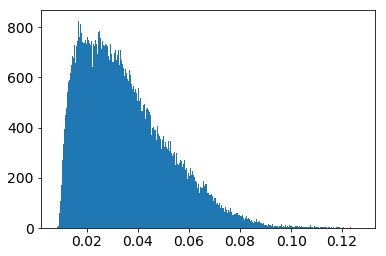

In [134]:
plt.hist(df.Z12, bins=1000);

In [129]:
np.quantile(df.Z12, 0.16)

0.01782369271753486

In [131]:
np.median(df.Z12)

0.031738126971816896

In [130]:
np.quantile(df.Z12, 0.84)

0.05263494038593203

(array([2.9749e+04, 5.8988e+04, 6.1376e+04, 4.9680e+04, 2.9190e+04,
        1.3859e+04, 4.9860e+03, 1.7560e+03, 3.6600e+02, 5.0000e+01]),
 array([3.21709582e-05, 9.18130030e-03, 1.83304296e-02, 2.74795590e-02,
        3.66286883e-02, 4.57778177e-02, 5.49269470e-02, 6.40760764e-02,
        7.32252057e-02, 8.23743351e-02, 9.15234644e-02]),
 <a list of 10 Patch objects>)

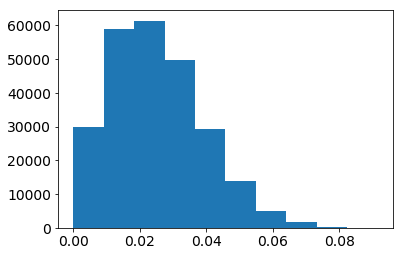

In [53]:
plt.hist(df.Z23)

In [79]:
df2 = pd.read_csv("K23/K23_logm_SPOCK.csv", index_col=0)

In [80]:
%%time
dasklabels = dd.from_pandas(df2, npartitions=n_workers)
df2 = dasklabels.apply(dfrow_to_Zs_saved, axis=1, meta=df2).compute(scheduler='processes')
df2.to_csv("Kepler-{0}_default_priors_SPOCK.csv".format(KepID))

CPU times: user 852 ms, sys: 140 ms, total: 992 ms
Wall time: 1min 35s


In [94]:
df2 = pd.read_csv("Kepler-{0}_default_priors_SPOCK.csv".format(KepID), index_col=0)

(array([11407.,  7130.,  2895.,  1983.,  1560.,  1061.,   524.,   304.,
          144.,    45.]),
 array([6.86741422e-04, 1.44311943e-01, 2.87937145e-01, 4.31562347e-01,
        5.75187549e-01, 7.18812751e-01, 8.62437953e-01, 1.00606315e+00,
        1.14968836e+00, 1.29331356e+00, 1.43693876e+00]),
 <a list of 10 Patch objects>)

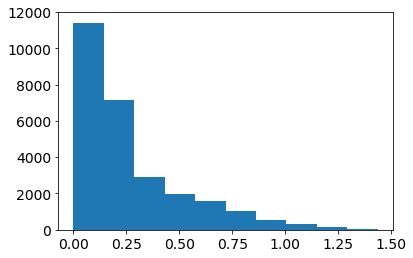

In [82]:
plt.hist(df2.Z12)

(array([17527.,  1830.,  2071.,  1960.,  1616.,  1062.,   567.,   279.,
          112.,    29.]),
 array([1.87317467e-04, 1.45700537e-01, 2.91213756e-01, 4.36726975e-01,
        5.82240195e-01, 7.27753414e-01, 8.73266633e-01, 1.01877985e+00,
        1.16429307e+00, 1.30980629e+00, 1.45531951e+00]),
 <a list of 10 Patch objects>)

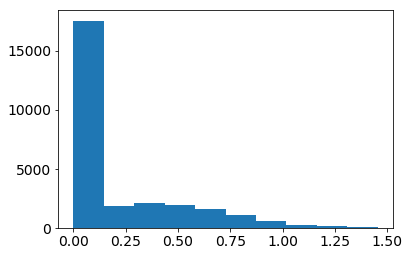

In [83]:
plt.hist(df2.Z23)

In [89]:
df3 = pd.read_csv("K23/K23_logm_nbody.csv", index_col=0)

In [90]:
%%time
dasklabels = dd.from_pandas(df3, npartitions=n_workers)
df3 = dasklabels.apply(dfrow_to_Zs_saved, axis=1, meta=df3).compute(scheduler='processes')
df3.to_csv("Kepler-{0}_default_priors_nbody.csv".format(KepID))

CPU times: user 283 ms, sys: 86 ms, total: 369 ms
Wall time: 25.7 s


In [91]:
df3 = pd.read_csv("Kepler-{0}_default_priors_nbody.csv".format(KepID), index_col=0)

(array([3.097e+03, 2.443e+03, 1.075e+03, 3.810e+02, 8.300e+01, 1.900e+01,
        9.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00124345, 0.07479028, 0.14833711, 0.22188395, 0.29543078,
        0.36897762, 0.44252445, 0.51607129, 0.58961812, 0.66316495,
        0.73671179]),
 <a list of 10 Patch objects>)

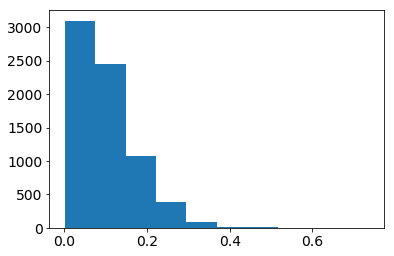

In [92]:
plt.hist(df3.Z12)

(array([6.563e+03, 4.720e+02, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        7.000e+00, 3.500e+01, 1.600e+01, 9.000e+00]),
 array([3.41437925e-04, 1.04720890e-01, 2.09100343e-01, 3.13479796e-01,
        4.17859248e-01, 5.22238701e-01, 6.26618153e-01, 7.30997606e-01,
        8.35377058e-01, 9.39756511e-01, 1.04413596e+00]),
 <a list of 10 Patch objects>)

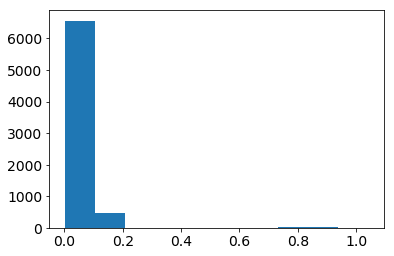

In [93]:
plt.hist(df3.Z23)

Text(0.5, 1.0, 'Z12')

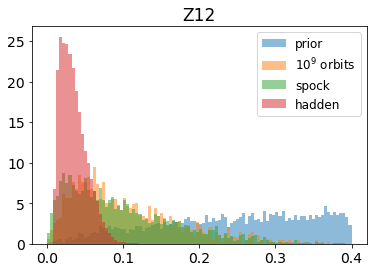

In [142]:
x, bins, x = plt.hist(df2.loc[:10000].Z12, alpha=0.5, density=True, label="prior", bins=100, range=[0,0.4])
plt.hist(df3.loc[df3.probstability > 0].Z12, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)
# plt.hist(df3.Z12, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z12, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z12, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability)
plt.hist(df.Z12, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z12")

In [147]:
np.quantile(df3.loc[df3.probstability > 0].Z12, 0.84)
np.quantile(df3.loc[df3.probstability > 0].Z23, 0.84)

0.08770775442418524

Text(0.5, 1.0, 'Z23')

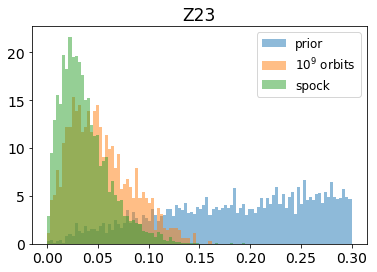

In [144]:
x, bins, x = plt.hist(df2.loc[:10000].Z23, alpha=0.5, density=True, label="prior", bins=100, range=[0,0.3])
plt.hist(df3.loc[df3.probstability > 0].Z23, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)
# plt.hist(df3.Z23, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z23, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z23, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability)
# plt.hist(df.Z23, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z23")

In [114]:
df4 = df3.loc[df3.probstability > 0]
df4 = df4.loc[df4.Z12 > 0.25]

In [136]:
df4;

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae7a6e3fd0>)

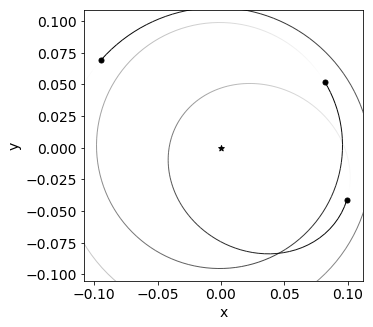

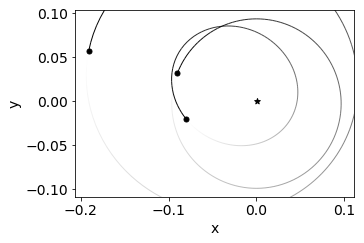

In [138]:
sim = rebound.SimulationArchive("K23/K23_logm_start_%d.bin"%(int(df4.sim.iloc[0])))[0]
rebound.OrbitPlot(sim)
P1 = sim.particles[1].P
maxorbs = 1e6
sim.integrate(maxorbs * P1, exact_finish_time=0)
rebound.OrbitPlot(sim)

In [143]:
sim = rebound.SimulationArchive("K23/K23_logm_start_%d.bin"%(int(df4.sim.iloc[0])))[0]
sim.status()

---------------------------------
REBOUND version:     	3.12.1
REBOUND built on:    	Mar 17 2020 15:28:58
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.004322
---------------------------------
<rebound.Particle object, m=1.055829268737029 x=-6.943939601097393e-06 y=-4.424962041816582e-06 z=2.021073987697693e-08 vx=0.00014755501084640118 vy=-0.0002379244931923872 vz=5.243681923140896e-06>
<rebound.Particle object, m=4.16932561680511e-06 x=0.09920050660794036 y=-0.04162269512779508 z=0.0007410123772195609 vx=0.693439582259841 vy=2.193409158582374 vz=-0.04591066073455772>
<rebound.Particle object, m=8.863647054784092e-05 x=0.08191852207752205 y=0.05183126567123616 z=-0.00033048129214195915 vx=-1.7068628710729172 vy=2.825140240627406 vz=-0.05981850640832024>
<rebound.Particle object, m=3.6317427139575493e-06 x=-0.09443213318737342 y=0.06922366822546742 z=0.0013393247013907276 vx=-2.0358749492327943 vy=-2.2985805219